# Tully problem 1 

In this notebook, we'll try to use Landau-Zener formula to compute hopping probabilities

In [1]:
import sys
import cmath
import math
import os

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import units
from libra_py import models_Tully
from libra_py import tsh
from libra_py import tsh_stat
from libra_py import tsh_algo1
from libra_py import data_conv

import matplotlib.pyplot as plt   # plots
import numpy as np
#from matplotlib.mlab import griddata

%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::complex<double>, std::allocator<std::complex<double> > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, s

## 1. Model Hamiltonian 

Define the parameters sets

    H_00 = A*(1.0-exp(-B*x)) x>0,  
         = A*(exp(B*x)-1.0 ) x<0
    H_11 = -H_00
    H_01 = C*exp(-D*x^2)


In [2]:
param_sets = [ {"model":1, "A":0.01, "B":1.6, "C":0.005, "D":1.0},
               {"model":1, "A":0.01, "B":1.6, "C":0.01, "D":1.0},
               {"model":1, "A":0.04, "B":1.6, "C":0.02, "D":1.0}
             ]

Define the x grid

In [3]:
xmin = -10.0
xmax = 10.0
dx = 0.01

X = []
nsteps = int((xmax - xmin) / dx) + 1

for i in range(nsteps):
    X.append(xmin + i * dx)

Define how to compute diabatic Hamiltonians to be called by the nHamiltonian object

In [4]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None

    Id = Cpp2Py(full_id)
    indx = Id[-1]

    if model==1:
        res = models_Tully.Tully1(q.col(indx), params)
    elif model==2:
        res = models_Tully.Tully2(q.col(indx), params)
    elif model==3:
        res = models_Tully.Tully3(q.col(indx), params)

    return res


In [5]:
ham = nHamiltonian(2, 2, 1) # ndia, nadi, nnucl
ham.init_all(2)


H00, H11, H01 = [], [], []     # diabatic PES
dH00, dH11, dH01 = [], [], []  # derivatives of diabatic PES
E00, E11 = [], []              # adiabatic PES
dE00, dE11, D01 = [], [], []   # derivatives of adiabatic PES

sz = len(param_sets)
for iset in range(sz):
        
    h00, h11, h01 = [], [], []     # diabatic PES
    dh00, dh11, dh01 = [], [], []  # derivatives of diabatic PES
    e00, e11 = [], []              # adiabatic PES
    de00, de11, d01 = [], [], []   # derivatives of adiabatic PES
    
    for i in range(nsteps):
                
        q = MATRIX(1,1); q.set(0, 0, X[i])        
        
        # Diabatic properties
        ham.compute_diabatic(compute_model, q, param_sets[iset])
            
        # Adiabatic properties
        ham.compute_adiabatic(1);       

        # Pack all the properties into lists
        h00.append(ham.get_ham_dia().get(0,0).real)
        h11.append(ham.get_ham_dia().get(1,1).real)
        h01.append(ham.get_ham_dia().get(0,1).real)    
    
        dh00.append(ham.get_d1ham_dia(0).get(0,0).real)
        dh11.append(ham.get_d1ham_dia(0).get(1,1).real)
        dh01.append(ham.get_d1ham_dia(0).get(0,1).real) 
        
        e00.append(ham.get_ham_adi().get(0,0).real)
        e11.append(ham.get_ham_adi().get(1,1).real)
        
        de00.append(ham.get_d1ham_adi(0).get(0,0).real)
        de11.append(ham.get_d1ham_adi(0).get(1,1).real)
        d01.append(ham.get_d1ham_adi(0).get(0,1).real) 

        
    H00.append(h00);   H11.append(h11);    H01.append(h01)
    dH00.append(dh00); dH11.append(dh11);  dH01.append(dh01)
    E00.append(e00);   E11.append(e11);    
    dE00.append(de00); dE11.append(de11);  D01.append(d01);    


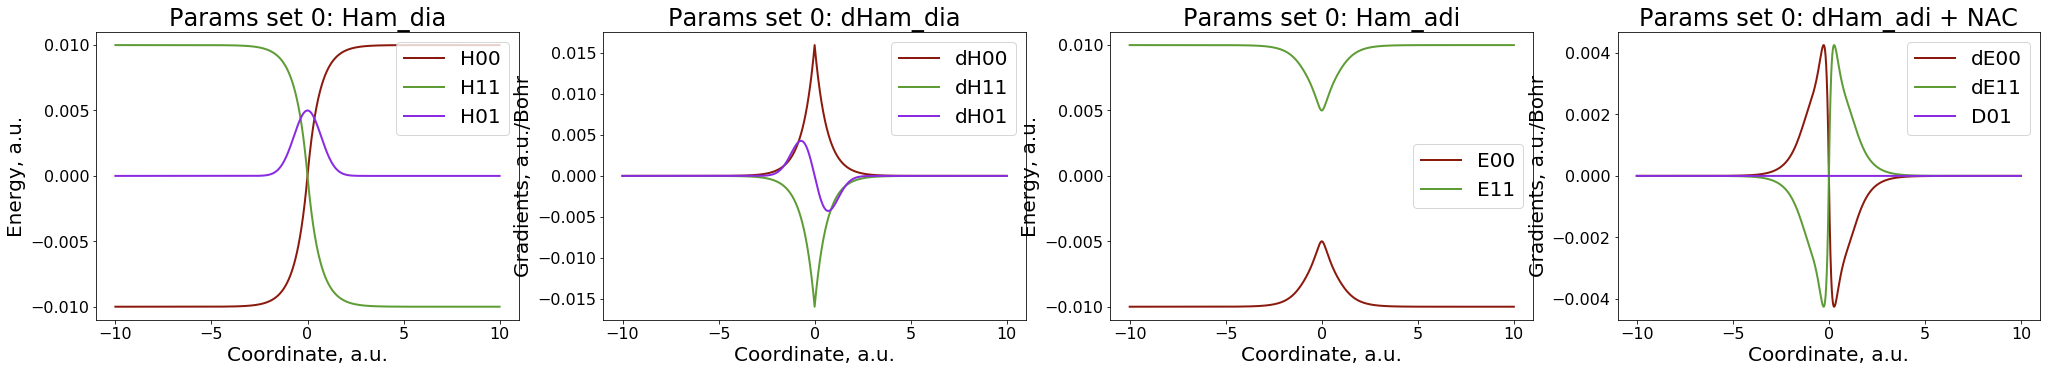

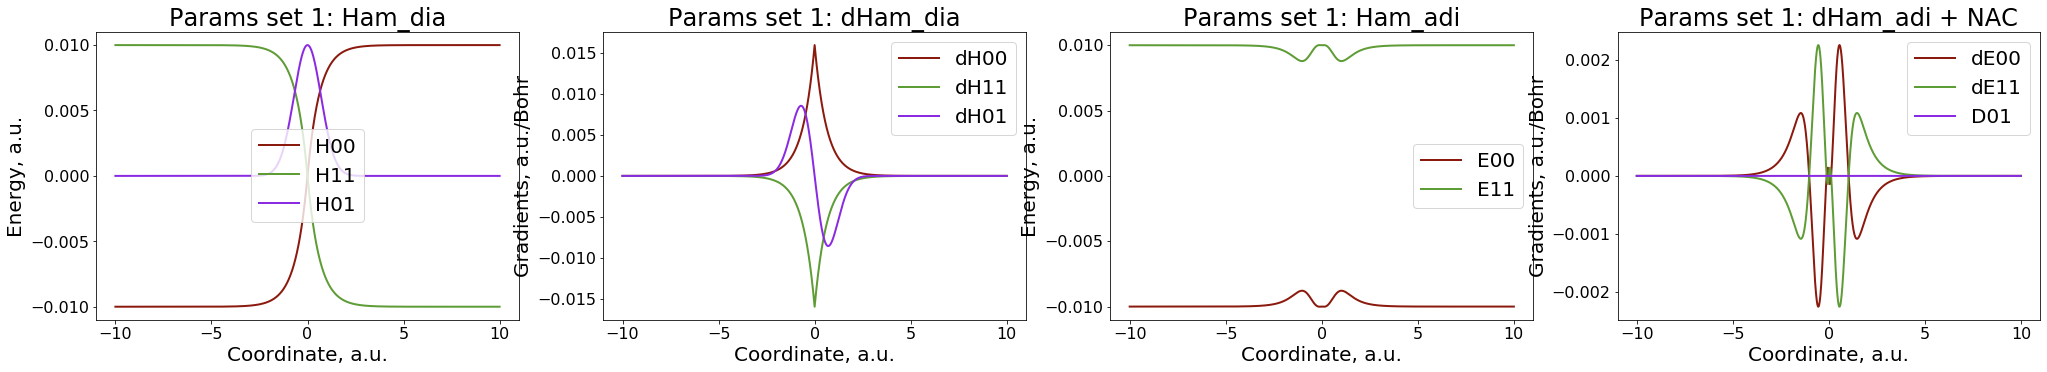

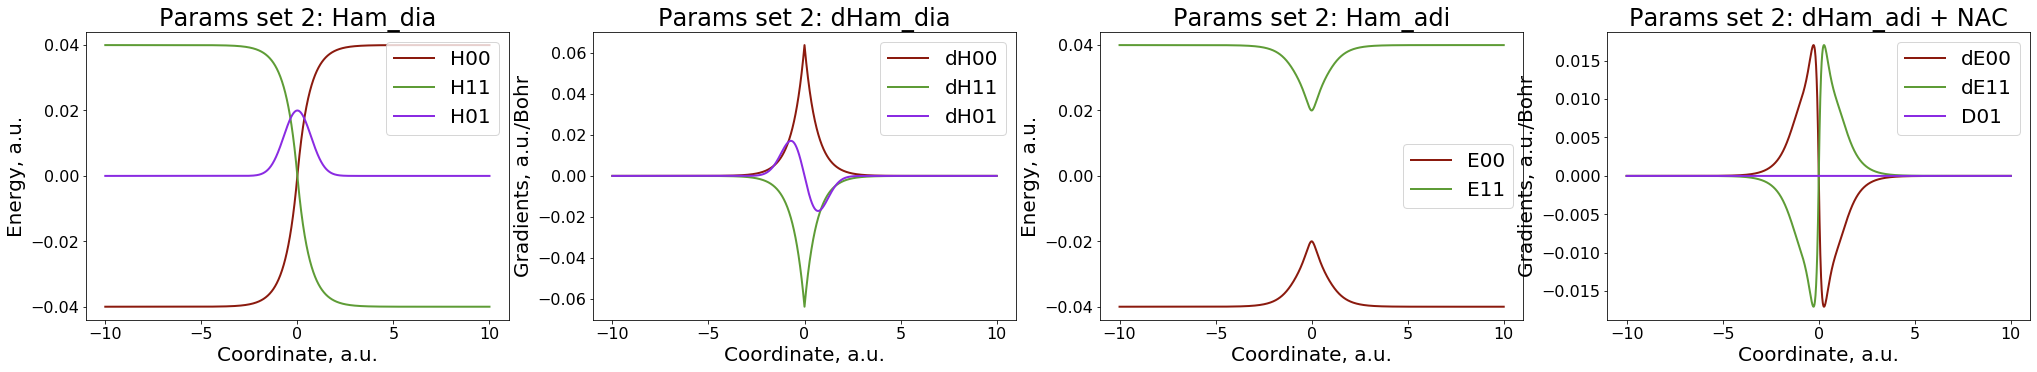

In [6]:
for i in range(sz):
    
    plt.figure(1, figsize=(36, 18)) # dpi=300, frameon=False)
    
    plt.subplot(sz, 4, 4*i+1)
    plt.title('Params set %i: Ham_dia' % (i) )
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Energy, a.u.')
    plt.plot(X, H00[i], label='H00', linewidth=2, color = colors["11"]) 
    plt.plot(X, H11[i], label='H11', linewidth=2, color = colors["21"]) 
    plt.plot(X, H01[i], label='H01', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.subplot(sz, 4, 4*i+2)
    plt.title('Params set %i: dHam_dia' % (i))
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Gradients, a.u./Bohr')
    plt.plot(X, dH00[i], label='dH00', linewidth=2, color = colors["11"]) 
    plt.plot(X, dH11[i], label='dH11', linewidth=2, color = colors["21"]) 
    plt.plot(X, dH01[i], label='dH01', linewidth=2, color = colors["31"]) 
    plt.legend()
    
    plt.subplot(sz, 4, 4*i+3)
    plt.title('Params set %i: Ham_adi' % (i))
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Energy, a.u.')
    plt.plot(X, E00[i], label='E00', linewidth=2, color = colors["11"]) 
    plt.plot(X, E11[i], label='E11', linewidth=2, color = colors["21"])     
    plt.legend()
               
    plt.subplot(sz, 4, 4*i+4)
    plt.title('Params set %i: dHam_adi + NAC' % (i))
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Gradients, a.u./Bohr')
    plt.plot(X, dE00[i], label='dE00', linewidth=2, color = colors["11"]) 
    plt.plot(X, dE11[i], label='dE11', linewidth=2, color = colors["21"])     
    plt.plot(X, D01[i], label='D01', linewidth=2, color = colors["31"])     
    plt.legend()               

    plt.show()
    plt.close()

## 2. Scattering calculations with different initial momenta

In [7]:
def run_tsh(p0, iset, tsh_method, rnd):
    """    
    iset - index of the parameters set
    tsh_method : 0 - FSSH, 3 - LZ
    """
    
    # Dimensionality and dynamical variables
    ndia, nadi, nnucl, ntraj = 2, 2, 1, 50

    mean_q = MATRIX(nnucl,1);   mean_q.set(0,0, -5.0)
    sigma_q = MATRIX(nnucl,1);  sigma_q.set(0,0, 0.0)
    mean_p = MATRIX(nnucl,1);   mean_p.set(0,0, p0)
    sigma_p = MATRIX(nnucl,1);  sigma_p.set(0,0, 0.0)

    q = MATRIX(nnucl,ntraj);  tsh.sample(q, mean_q, sigma_q, rnd)
    p = MATRIX(nnucl,ntraj);  tsh.sample(p, mean_p, sigma_p, rnd)
    iM = MATRIX(nnucl,1);     iM.set(0,0, 1.0/2000.0)

    istate = 0
    Cdia, Cadi = CMATRIX(ndia, ntraj), CMATRIX(nadi, ntraj)
    states = intList() 

    for traj in range(ntraj):
        Cadi.set(istate, traj, 1.0+0.0j);  
        states.append(istate) 
    
    # Dynamics (Simulation) parameters
    dyn_params = { "rep":1, "rep_sh":1, "rep_lz":0, "tsh_method":tsh_method, "use_boltz_factor":0,
                   "nsteps":5000, "tsh_version":2,
                   "Temperature":300.0, "do_reverse":1, "vel_rescale_opt":1, "dt":1.0 }

    res = tsh_algo1.run_tsh(q, p, iM, Cdia, Cadi, states, param_sets[iset], dyn_params, compute_model, rnd)
    
    return res

In [8]:
def run_scan(iset, tsh_method, rnd):
    
    # Define all possible momenta
    P0 = [5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0]
    
    # Run scattering calcs
    scan_res = []
    for p0 in P0:
        res = run_tsh(p0, iset, tsh_method, rnd)
        scan_res.append(res) 
        

    # Extract the results
    # Format: 
    #   0      1      2       3        4        5           6          7        8            9       10        11            12        13        14 
    #obs_T, obs_q, obs_p, obs_Ekin, obs_Epot, obs_Etot, obs_dEkin, obs_dEpot, obs_dEtot, obs_Cadi, obs_Cdia, obs_dm_adi, obs_dm_dia, obs_pop  obs_states
    #
    # scan_res[icond][ivar][istep][i]       for lists
    # scan_res[icond][ivar][istep].get(i,j) for matrices

    nsteps = len(scan_res[0][0])
    ntraj = len(scan_res[0][14][0])

    icond = 0 
    last_q = scan_res[icond][1][nsteps-1]
    last_states = scan_res[icond][14][nsteps-1]
    
    
    # Compute the statistics of scattering and transitions
    ncond = len(P0)
    P_re, P_tr = [], []

    for icond in range(ncond):
    
        last_q = scan_res[icond][1][nsteps-1]
        last_states = scan_res[icond][14][nsteps-1]

        pop_refl, pop_transm = tsh_algo1.probabilities_1D_scattering(last_q, last_states, 2, {"act_dof":0, "left_boundary":-5.0, "right_boundary":5.0} )
        P_re.append(pop_refl)
        P_tr.append(pop_transm)

    # Convert results into lists for easy plotting
    p_re0 = data_conv.unpack1(P_re, 0, 0, 2)
    p_re1 = data_conv.unpack1(P_re, 1, 0, 2)
    p_tr0 = data_conv.unpack1(P_tr, 0, 0, 2)
    p_tr1 = data_conv.unpack1(P_tr, 1, 0, 2)

    return [p_re0, p_re1, p_tr0, p_tr1]


In [9]:
rnd = Random()

sz = len(param_sets)
TSH = []
LZ = []

for iset in range(sz):
    
    res_tsh = run_scan(iset, 0, rnd) # TSH
    res_lz = run_scan(iset, 3, rnd) # LZ
    
    TSH.append(res_tsh)
    LZ.append(res_lz)


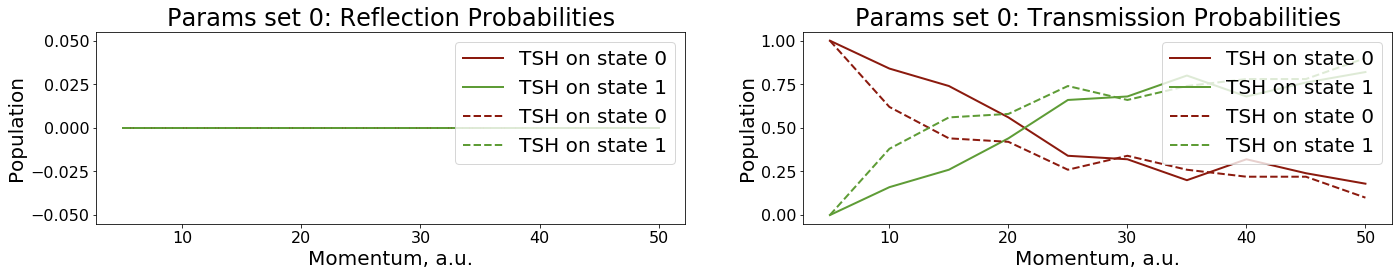

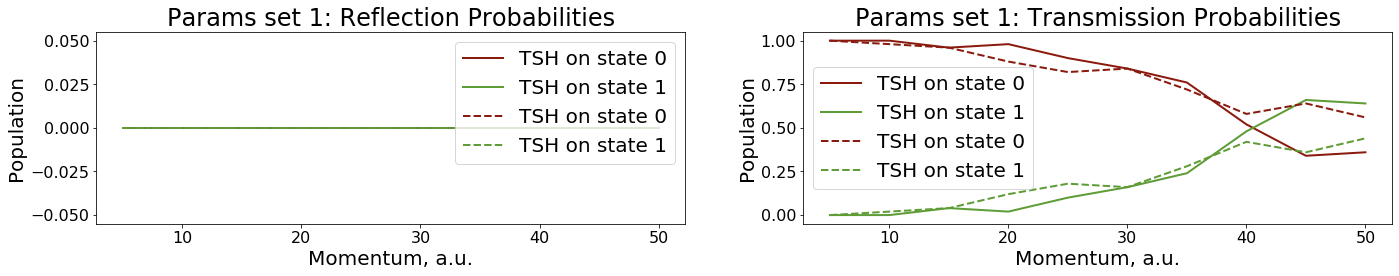

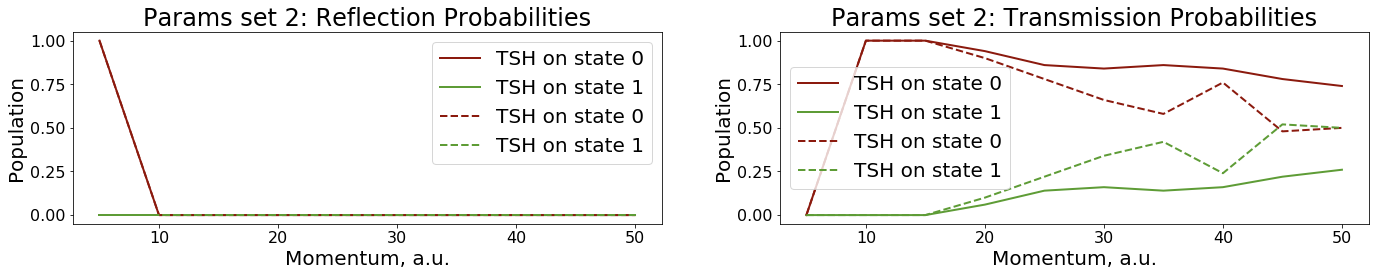

In [10]:
P0 = [5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0]

for i in range(sz):
    
    plt.figure(1, figsize=(24, 12)) # dpi=300, frameon=False)
    plt.subplot(sz, 2, 2*i+1)
    plt.title('Params set %i: Reflection Probabilities' % (i) )
    plt.xlabel('Momentum, a.u.')
    plt.ylabel('Population')
    plt.plot(P0, TSH[i][0], label='TSH on state 0', linewidth=2, color = colors["11"])   # p_re0
    plt.plot(P0, TSH[i][1], label='TSH on state 1', linewidth=2, color = colors["21"])   # p_re1
    plt.plot(P0, LZ[i][0], "--", label='TSH on state 0', linewidth=2, color = colors["11"])   # p_re0
    plt.plot(P0, LZ[i][1], "--", label='TSH on state 1', linewidth=2, color = colors["21"])   # p_re1
    plt.legend()

    plt.subplot(sz, 2, 2*i+2)
    plt.title('Params set %i: Transmission Probabilities' % (i) )
    plt.xlabel('Momentum, a.u.')
    plt.ylabel('Population')
    plt.plot(P0, TSH[i][2], label='TSH on state 0', linewidth=2, color = colors["11"])   # p_tr0
    plt.plot(P0, TSH[i][3], label='TSH on state 1', linewidth=2, color = colors["21"])   # p_tr1        
    plt.plot(P0, LZ[i][2], "--", label='TSH on state 0', linewidth=2, color = colors["11"])   # p_re0
    plt.plot(P0, LZ[i][3], "--", label='TSH on state 1', linewidth=2, color = colors["21"])   # p_re1
    plt.legend()

    plt.show()
    plt.close()